In [3]:
import streaming
from streaming.base.format.mds.encodings import Encoding, _encodings
import numpy as np
from typing import Any
import torch
from streaming import StreamingDataset


class np32(Encoding):
    def encode(self, obj: Any) -> bytes:
        return obj.tobytes()

    def decode(self, data: bytes) -> Any:
        return np.frombuffer(data, np.float32)


_encodings["np32"] = np32
remote_train_dir = "/root/bigdisk/project_structured_prompt/stage_2_gligen_train/grit_mds_train"
remote_val_dir = "/root/bigdisk/project_structured_prompt/stage_2_gligen_train/grit_mds_test/data"
import os
import shutil


local_train_dir = "./local_train_dir"
if os.path.exists(local_train_dir):
    shutil.rmtree(local_train_dir)

local_val_dir = "./local_val_dir"
if os.path.exists(local_val_dir):
    shutil.rmtree(local_val_dir)

streaming.base.util.clean_stale_shared_memory()


train_dataset = StreamingDataset(
    local=local_train_dir,
    remote=remote_train_dir,
    split=None,
    shuffle=True,
    shuffle_algo="naive",
    num_canonical_nodes=1,
)

val_dataset = StreamingDataset(
    local=local_val_dir,
    remote=remote_val_dir,
    split=None,
    shuffle=False,
    num_canonical_nodes=1,
)

print("# PTI : Loaded dataset")
train_batch_size = 32
dataloader_num_workers = 4

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    num_workers=dataloader_num_workers,
)

# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset,
#     batch_size=train_batch_size,
#     num_workers=dataloader_num_workers,
# )

Because `predownload` was not specified, it will default to 8*batch_size if batch_size is not None, otherwise 64. Prior to Streaming v0.7.0, `predownload` defaulted to max(batch_size, 256 * batch_size // num_canonical_nodes).
Because `predownload` was not specified, it will default to 8*batch_size if batch_size is not None, otherwise 64. Prior to Streaming v0.7.0, `predownload` defaulted to max(batch_size, 256 * batch_size // num_canonical_nodes).


# PTI : Loaded dataset


In [4]:
batch = next(iter(train_dataloader))

Because `shuffle_block_size` was not specified, it will default to max(4_000_000 // num_canonical_nodes, 1 << 18) if num_canonical_nodes is not None, otherwise 262144. Prior to Streaming v0.7.0, `shuffle_block_size` defaulted to 262144.


/root/bigdisk/cu122py310/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/root/bigdisk/cu122py310/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppre

In [6]:

from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionPipeline

model = "stabilityai/your-stable-diffusion-model"
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to("cuda:0")

In [31]:
from diffusers.image_processor import VaeImageProcessor
i = 14
vae_latent = batch["vae_output"].reshape(-1, 4, 96, 96)[i:i+1].cuda()
x = vae.decode(vae_latent.cuda()).sample
img = VaeImageProcessor().postprocess(image = x.detach(), do_denormalize = [True, True])[0]
caption = batch['caption_output'][i]

Drapes, heated floors and woodsy interior provide <|0|><|0|><|712|><|712|>a cozy living space


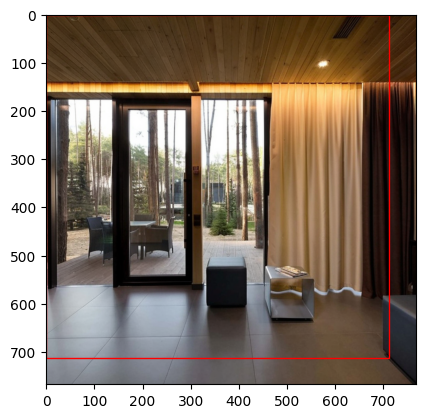

In [32]:
import re
def visualize_with_bounding_boxes(image, caption_structure):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    print(caption)
    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # extract noun chunks from caption_structure
    # capture <|(x_min)|><|(y_min)|><|(x_max)|><|(y_max)|>
    noun_chunks = re.findall(r"<\|(\d+)\|\><\|(\d+)\|\><\|(\d+)\|\><\|(\d+)\|\>", caption_structure)
    noun_chunks = [(int(x_min), int(y_min), int(x_max), int(y_max)) for x_min, y_min, x_max, y_max in noun_chunks]
    
    
    # Plot bounding boxes
    for chunk in noun_chunks:
        # Un-normalize bounding box coordinates
        # x_min = chunk[0] * image.width
        # y_min = chunk[1] * image.height
        # width = (chunk[4] - chunk[2]) * image.width
        # height = (chunk[5] - chunk[3]) * image.height
        x_min, y_min, x_max, y_max = chunk
        width, height = x_max - x_min, y_max - y_min
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

visualize_with_bounding_boxes(img, caption)